In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Visualizing Distortion
Before starting the project proper, let visualize the effects of the radial distortion parameters in changing a scene.

In [2]:
n = 21
x = np.linspace(-1,1,n)
x_grid = np.tile(x,n)
Y = np.ones((n,n))
Y = np.dot(np.diag(x),Y)
y_grid = Y.reshape(n**2)

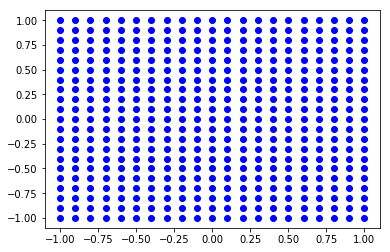

In [3]:
plt.plot(x_grid,y_grid,'bo')

In [4]:
def distort(A,k1,k2,k3):
    N = A.shape[0]
    r2 = (A[:,0]**2 + A[:,1]**2).reshape(N,1)
    R = np.hstack((r2,r2))
    distortion = np.ones((N,2)) + k1*R + k2*R**2 + k3*R**3
    B = A*distortion
    return B

In [5]:
A = np.hstack((x_grid.reshape((n**2,1)),y_grid.reshape((n**2,1))))

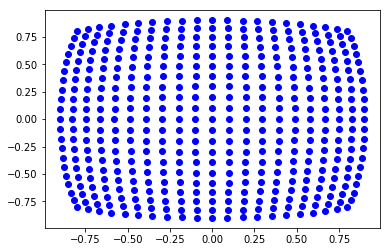

In [6]:
# Barrel Distortion
# negative k_1 value
B = distort(A,-.1,0,0)
plt.plot(B[:,0],B[:,1],'bo')

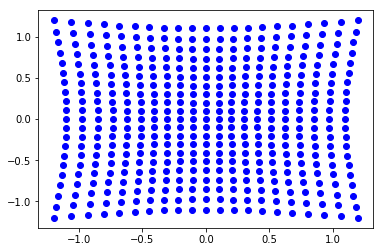

In [7]:
# Pincushion Distortion
# positive k_1 value
B = distort(A,.1,0,0)
plt.plot(B[:,0],B[:,1],'bo')

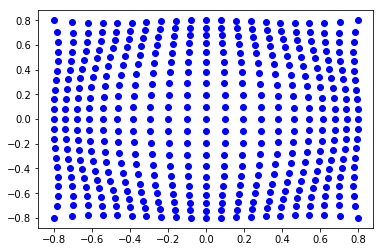

In [8]:
# Mustachian distortion
B = distort(A,-.3,.1,0)
plt.plot(B[:,0],B[:,1],'bo')

# Camera Calibration
We start out by testing the findChessboardCorners function on our first calibration image.

In [9]:
dir_path = './camera_cal/'
file_path = dir_path+'calibration'+str(1)+'.jpg'

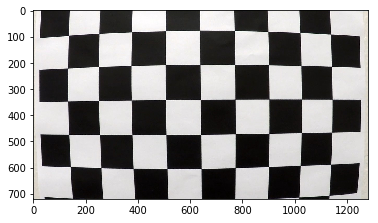

In [10]:
img = cv2.imread(file_path)
#change from BGR to RGB for plotting
plt.imshow(img[:,:,::-1])

Looks like we have a bit of barrel distortion here.  We expect that the k_1 distortion coefficient will be negative.

In [11]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(img, (9,5), None)
print(ret)

True


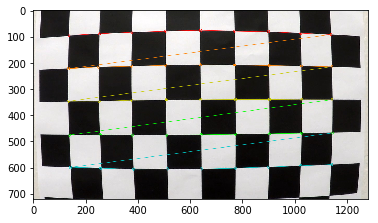

In [12]:
img_copy = img.copy()
cv2.drawChessboardCorners(img_copy,(9,5),corners,ret)
plt.imshow(img_copy[:,:,::-1])

Now that we see how the findChessboardCorners function works, we define a couple of helper functions to iterate over all calibration images.

In [13]:
# create_grid returns a matrix whose columns are (x,y,z) coordinates of a num_x-by-num_y grid
# all z values are set to 0
# the points are given going row by row, where the x step size is size_x 
# and the y step size is size_y
def create_grid(num_x,num_y,size_x = 1., size_y = 1.):
    x = np.linspace(0,(num_x-1)*size_x, num_x)
    y = np.linspace(0,(num_y-1)*size_y, num_y)
    x_grid = np.tile(x,num_y).reshape(num_x*num_y,1)
    y_grid = np.dot(np.diag(y),np.ones((num_y,num_x)))
    y_grid = y_grid.reshape((num_x*num_y,1))
    return np.hstack((x_grid,y_grid,np.zeros((num_x*num_y,1)))).astype(np.float32)

In [14]:
# this function compiles arrays of objpoints and imgpoints by iterating over all calibration images
# we try to detect either (9,5) or (9,6) grid intersections with findChessboardCorners
# the objpoints points are created by calling create_grid with the appropriate grid size
def create_obj_and_img_points(x_step = 1.0, y_step =1.0):
    objpoints = []
    imgpoints = []
    for i in range(1,21):
        file_path = './camera_cal/calibration'+str(i)+'.jpg'
        img = cv2.imread(file_path)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # try (9,6) and (9,5)
        ret96, corners96 = cv2.findChessboardCorners(img, (9,6), None)
        ret95, corners95 = cv2.findChessboardCorners(img, (9,5), None)
        if ret96:
            print('True 96 image {}'.format(i))
            objpoints.append(create_grid(9,6,size_x = x_step, size_y = y_step))
            imgpoints.append(corners96)
        elif ret95:
            print('True 95 image {}'.format(i))
            objpoints.append(create_grid(9,5,size_x = x_step, size_y = y_step))
            imgpoints.append(corners95)
    return objpoints, imgpoints

In [15]:
objpoints, imgpoints = create_obj_and_img_points()
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape,None,None)

True 95 image 1
True 96 image 2
True 96 image 3
True 96 image 6
True 96 image 7
True 96 image 8
True 96 image 9
True 96 image 10
True 96 image 11
True 96 image 12
True 96 image 13
True 96 image 14
True 96 image 15
True 96 image 16
True 96 image 17
True 96 image 18
True 96 image 19
True 96 image 20


We were able to find chessboard corners in all images except for images 4 and 5.  Let's take a look at these unsuccessful images.

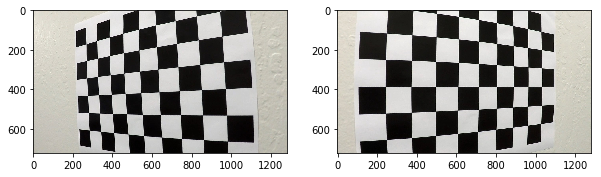

In [16]:
# images 4 and 5
file_path = dir_path+'calibration'+str(4)+'.jpg'
img4 = cv2.imread(file_path)
file_path = dir_path+'calibration'+str(5)+'.jpg'
img5 = cv2.imread(file_path)
plt.figure(figsize = (10,20))
plt.subplot(1,2,1)
plt.imshow(img4[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(img5[:,:,::-1])

We see that in these cases some of the corner intersections are obscured so that neither a (9,5) or a (9,6) grid could be detected.

## Reprojection error
Let's see how good the camera calibration error we found is by looking at the reprojection error.

<Container object of 18 artists>

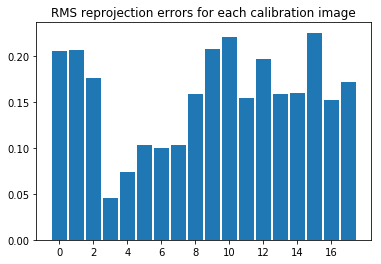

In [17]:
# plot histogram of reprojection error
N = len(objpoints)
error = np.zeros(N)
for i in range(N):
    pred = cv2.projectPoints(objpoints[i],rvecs[i],tvecs[i],mtx,dist)[0]
    error[i] = np.linalg.norm(imgpoints[i] - pred)/pred.shape[0]
plt.title('RMS reprojection errors for each calibration image')
plt.xticks(range(0,18,2),range(0,18,2))
plt.bar(range(N),error, width = 1/1.1)

The root mean squared error is under 1 pixel for all of the images.  This looks pretty good.

## What effect does scale have on the distortion parameters and camera matrix?
So far we used that the grid spacing was 1 unit in our chessboard images.  If we change the units so that the spacing is 0.1 instead, what effect does this have on our calibration parameters?

In [18]:
# change x_step and y_step to 0.1 and perform calibration again
objpoints, imgpoints = create_obj_and_img_points(x_step = 0.1, y_step = 0.1)
ret2,mtx2,dist2,rvecs2,tvecs2 = cv2.calibrateCamera(objpoints,imgpoints,gray.shape,None,None)

True 95 image 1
True 96 image 2
True 96 image 3
True 96 image 6
True 96 image 7
True 96 image 8
True 96 image 9
True 96 image 10
True 96 image 11
True 96 image 12
True 96 image 13
True 96 image 14
True 96 image 15
True 96 image 16
True 96 image 17
True 96 image 18
True 96 image 19
True 96 image 20


In [19]:
np.max(dist-dist2)

2.0201875211437251e-07

In [20]:
np.max(mtx-mtx2)

3.8129387007757032e-05

Very interesting!  The intrinsic camera parameters are independent of the physical units in which we measure our grid.  Now let's look at the extrinsic parameters.

In [21]:
print(rvecs[0])
print(rvecs2[0])

[[ 0.0353985 ]
 [-0.03139019]
 [-0.00754155]]
[[ 0.0353985 ]
 [-0.03139019]
 [-0.00754155]]


The rotation matrix does not change with our change in scale.  I suppose this makes sense as the change in scale does not affect the relative orientation of the camera and the chessboard.

In [22]:
print(tvecs[0])
print(tvecs2[0])

[[-4.23624621]
 [-2.31932895]
 [ 8.47119989]]
[[-0.42362462]
 [-0.23193287]
 [ 0.84711998]]


The translation vector is multiplied by our scale factor.  This seems to be the only parameter that is affected by the scale change, and also behaves as we expect.

## Undistorting an image
As a further test of the camera calibration, let's look at one of the images we did not calibrate on, image 4, and see how undistortion performs on it.

In [23]:
file_path = dir_path+'calibration'+str(4)+'.jpg'
img = cv2.imread(file_path)

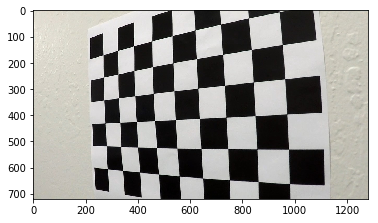

In [24]:
plt.imshow(img[:,:,::-1])

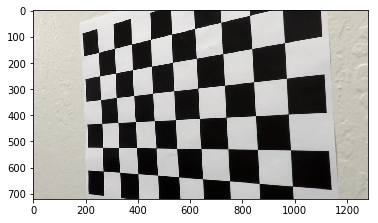

In [25]:
rectified = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(rectified[:,:,::-1])

The undistorted image looks fine, but it is difficult to tell by eye how much has changed.  For a more precise estimate, let's look at the reprojection error on this image.  To do this, we first have to find the corners in this image.  Luckily, this can be done, we just have to adjust the size of the grid we are looking for.

In [26]:
ret, corners = cv2.findChessboardCorners(img, (5,6), None)
print(ret)

True


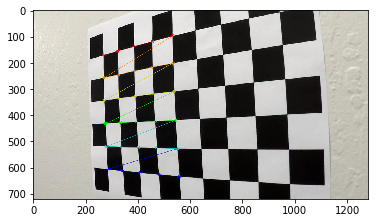

In [27]:
img_copy = img.copy()
cv2.drawChessboardCorners(img_copy,(5,6),corners,ret)
plt.imshow(img_copy[:,:,::-1])

The corners picked up look good.  Now let's find the rotation and translation of this image with respect to the camera coordinates using the solvePnP function.

In [28]:
gridpoints = create_grid(5,6)
ret, rvec4, tvec4 = cv2.solvePnP(gridpoints,corners,mtx,dist)
print(ret)

True


Now that we know the camera pose, we can compute the projection of the gridpoints and compare to the actual corner point locations to determine the reprojection error on this image.

In [29]:
out4 = cv2.projectPoints(gridpoints,rvec4,tvec4,mtx,dist)

In [30]:
print('root mean square error is {0:.4f}'.format(np.linalg.norm(out4[0]-corners)/30))
print('Maximum pixel deviation is {0:.4f}'.format(np.max(out4[0]-corners)))

root mean square error is 0.2150
Maximum pixel deviation is 2.2799


The performance on this new image is fairly good.  The average pixel error is as small as on the images we calibrated on, and the most any one point is off by is just over 2 pixels.

## Undistorting image 1
The barrel distortion was more obvious in the first calibration image.  Let's see the effect of undistortion on this image.

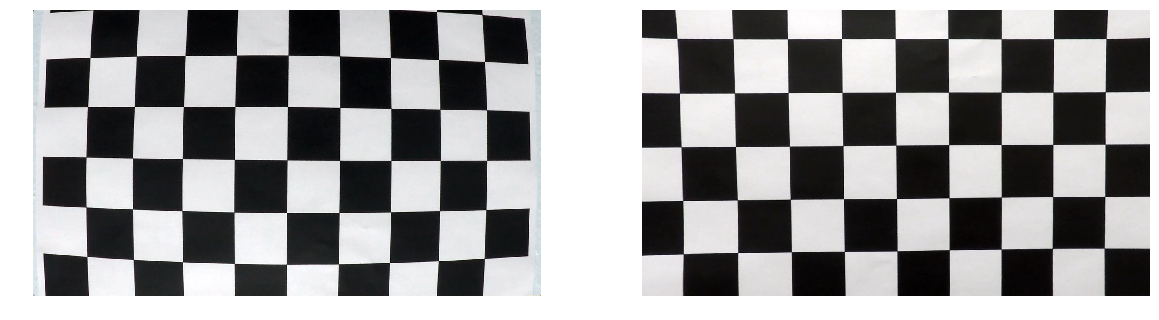

In [31]:
file_path = dir_path+'calibration'+str(1)+'.jpg'
img = cv2.imread(file_path)
rectified = cv2.undistort(img, mtx, dist, None, mtx)
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img[::-1])
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(rectified[:,:,::-1])

## Changing Perspective
Now let's test how the warpPerspective function to works to change calibration image 4 into a perspective of looking straight on at the chessboard.

As our source points, we take the 4 extreme found corners.

In [38]:
file_path = dir_path+'calibration'+str(4)+'.jpg'
img = cv2.imread(file_path)
ret, corners = cv2.findChessboardCorners(img, (5,6), None)
print(ret)

True


In [39]:
src = np.vstack((corners[0][0],corners[4][0],corners[25][0],corners[29][0]))
src

array([[ 269.50250244,  171.22302246],
       [ 533.50372314,   98.34186554],
       [ 285.41021729,  606.1605835 ],
       [ 559.11260986,  633.62548828]], dtype=float32)

In [40]:
x_dist = np.sqrt((src[0][0]-src[1][0])**2 + (src[0][1]-src[1][1])**2)
print(x_dist)
y_dist = np.sqrt((src[0][0]-src[2][0])**2 + (src[0][1]-src[2][1])**2)
print(y_dist)

273.876445805
435.228373835


In [41]:
dst = np.array([[219,186],[493,186],[219,621],[493,621]],dtype=np.float32)

[[  1.90463062e+00  -5.75775226e-02  -2.16564751e+02]
 [  5.76956313e-01   1.32330252e+00  -1.38420055e+02]
 [  1.14155825e-03   1.34249612e-05   1.00000000e+00]]


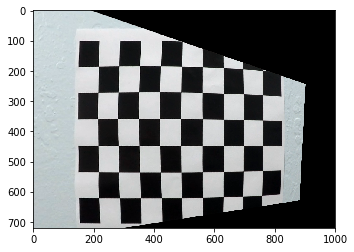

In [42]:
M = cv2.getPerspectiveTransform(src,dst)
print(M)
img_front = cv2.warpPerspective(img,M,(1000,720))
plt.imshow(img_front)

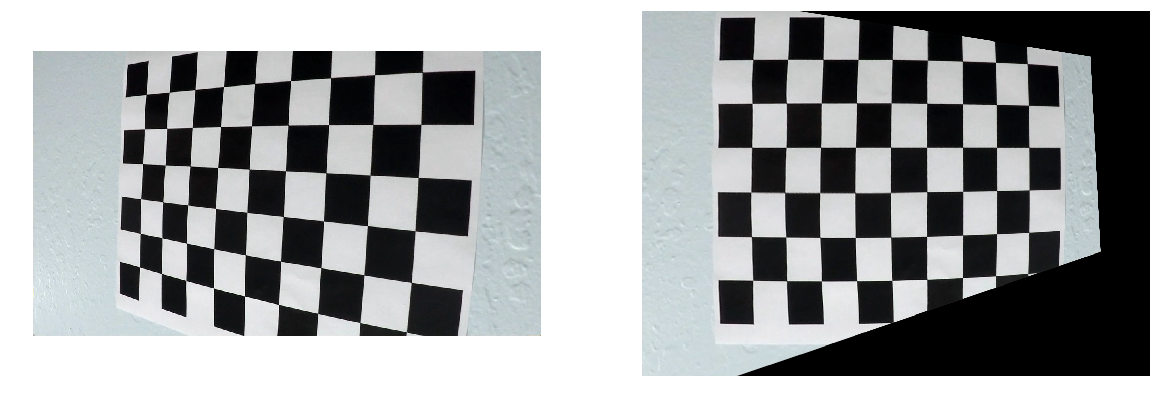

In [43]:
M = cv2.getPerspectiveTransform(src,dst)
img_front = cv2.warpPerspective(img,M,(1000,720))
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img[::-1])
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(img_front[::-1])

This looks like a fairly good transformation to a head on view.

## Interpretation of distortion coefficients
The Udacity notes give the following formula describing the role of the (radial) distortion coefficients: 
$$
x_{\mathrm{corrected}} = x_{\mathrm{distorted}}(1 + k_1 r^2 + k_2r^4 + k_3 r^6) \\
y_{\mathrm{corrected}} = y_{\mathrm{distorted}}(1 + k_1 r^2 + k_2r^4 + k_3 r^6)
$$
where $r = \sqrt{x_{\mathrm{corrected}}^2 + y_{\mathrm{corrected}}^2}$.  This formula seems to be taken from the book "Learning OpenCV 3" by Adrian Kaehler, Gary Bradski.

Elsewhere in the [openCV documentation](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html), the formula is given the other way around:
$$
x_{\mathrm{distorted}} = x_{\mathrm{ideal}}(1 + k_1 r^2 + k_2r^4 + k_3 r^6) \\
y_{\mathrm{distorted}} = y_{\mathrm{ideal}}(1 + k_1 r^2 + k_2r^4 + k_3 r^6)
$$
where $r = \sqrt{x_{\mathrm{ideal}}^2 + y_{\mathrm{ideal}}^2}$.  I have changed the name to 
$x_{\mathrm{ideal}}$ to reflect that this is the x-coordinate of a world point under an ideal pinhole projection.

Which formula is correct?  We write our own projectPoints function to find out.

In [44]:
# First we look at the projected points from the first calibration image
out=cv2.projectPoints(objpoints[0],rvecs[0],tvecs[0],mtx,dist)
out = out[0].reshape((45,2))

This is our own projectPoints function 
following the algorithm description given [here](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html).

In [45]:
def myProjectPoints(objpoints,rvec,tvec,mtx,dist):
    P = objpoints.T
    num_points = P.shape[1]
    num_dist_params = dist.shape[1]
    dist = dist.reshape(num_dist_params)
    R = cv2.Rodrigues(rvec)[0]
    # rotate and translate objpoints to coord system where center of image plane is (0,0,1)
    P1 = np.dot(R,P) + tvec
    # do pinhole projection
    P2 = P1[:2,:]/P1[2,:].reshape((1,num_points))
    # adjust for distortion
    r2 = P2[0,:]**2 + P2[1,:]**2
    radial_factor = 1 + dist[0]*r2 + dist[1]*r2**2 
    if num_dist_params > 4:
        radial_factor += dist[4]*r2**3
    tang_xcorr = 2*dist[2]*P2[0,:]*P2[1,:] + dist[3]*(r2 + 2*P2[0,:]**2)
    tang_ycorr = dist[2]*(r2+2*P2[1,:]**2) + 2*dist[3]*P2[0,:]*P2[1,:]
    P2[0,:] = P2[0,:]*radial_factor + tang_xcorr
    P2[1,:] = P2[1,:]*radial_factor + tang_ycorr
    # rescale and translate to pixel coordinates
    c = mtx[:2,2].reshape((2,1))
    P3 = np.dot(mtx[:2,:2],P2) + c
    return P3.T

In [46]:
myout = myProjectPoints(objpoints[0],rvecs[0],tvecs[0],mtx,dist)

In [47]:
np.max(myout - out)

7.5067782177029585e-06

We see that our myProjectPoints function has very good agreement with the projectPoints function used in openCV, up to the 5th decimal place.

In [48]:
# Now we write the projectPoints function according to the version of the formula given in 
# the Udacity notes
def UdacityProjectPoints(objpoints,rvec,tvec,mtx,dist):
    P = objpoints.T
    num_points = P.shape[1]
    num_dist_params = dist.shape[1]
    dist = dist.reshape(num_dist_params)
    R = cv2.Rodrigues(rvec)[0]
    # rotate and translate objpoints to coord system where center of image plane is (0,0,1)
    P1 = np.dot(R,P) + tvec
    # do pinhole projection
    P2 = P1[:2,:]/P1[2,:].reshape((1,num_points))
    # adjust for distortion
    r2 = P2[0,:]**2 + P2[1,:]**2
    radial_factor = 1 + dist[0]*r2 + dist[1]*r2**2 
    if num_dist_params > 4:
        radial_factor += dist[4]*r2**3
    tang_xcorr = 2*dist[2]*P2[0,:]*P2[1,:] + dist[3]*(r2 + 2*P2[0,:]**2)
    tang_ycorr = dist[2]*(r2+2*P2[1,:]**2) + 2*dist[3]*P2[0,:]*P2[1,:]
    # In the udacity formula, we divide by the radial factor
    # and subtract the tangential term
    P2[0,:] = P2[0,:]/radial_factor - tang_xcorr
    P2[1,:] = P2[1,:]/radial_factor - tang_ycorr
    # rescale and translate to pixel coordinates
    c = mtx[:2,2].reshape((2,1))
    P3 = np.dot(mtx[:2,:2],P2) + c
    return P3.T

In [49]:
Udacityout = UdacityProjectPoints(objpoints[0],rvecs[0],tvecs[0],mtx,dist)

In [50]:
np.max(Udacityout - out)

-28.022729913127819

We see that the Udacity formula produces a large discrepancy with the openCV projectPoints function.  We conclude that the meaning of the radial distortion coefficients in openCV is according to the formulas
$$
x_{\mathrm{distorted}} = x_{\mathrm{ideal}}(1 + k_1 r^2 + k_2r^4 + k_3 r^6) \\
y_{\mathrm{distorted}} = y_{\mathrm{ideal}}(1 + k_1 r^2 + k_2r^4 + k_3 r^6).
$$

## Moving on to lane line images
With our calibration done, we now move on to look at lane line images.  Our first step is to undistort these images.

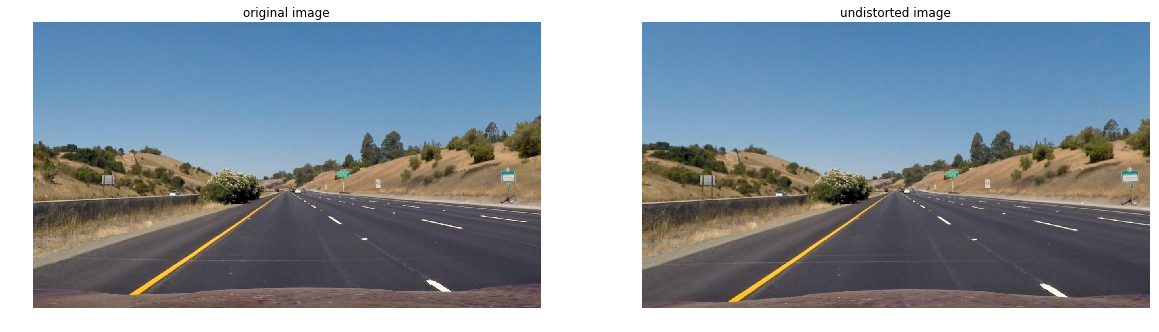

In [51]:
lane_file_path = './test_images/'
img_path = 'straight_lines1.jpg'
lane_img = cv2.imread(lane_file_path + img_path)
undistorted_lane_img = cv2.undistort(lane_img, mtx, dist, None, mtx)
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('original image')
plt.imshow(lane_img[:,:,::-1])
plt.subplot(1,2,2)
plt.title('undistorted image')
plt.axis('off')
plt.imshow(undistorted_lane_img[:,:,::-1])

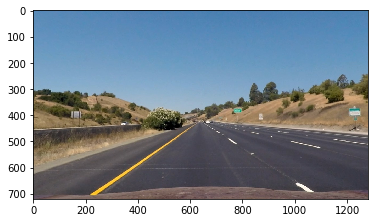

In [52]:
undistorted_lane_img = cv2.undistort(lane_img, mtx, dist, None, mtx)
plt.imshow(undistorted_lane_img[:,:,::-1])

In [53]:
cv2.imwrite('undistorted_straight.png',undistorted_lane_img)

True

## Changing perspective to overhead view

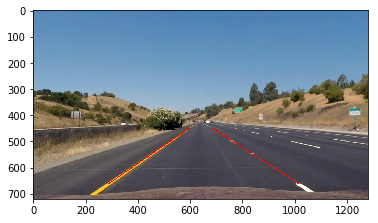

In [54]:
drawn_lines = undistorted_lane_img.copy()
cv2.line(drawn_lines,(289,661),(597,449),(0,0,255),2)
cv2.line(drawn_lines,(1014,661),(683,449),(0,0,255),2)
plt.imshow(drawn_lines[:,:,::-1])

In [55]:
src = np.array([[289,661],[597,449],[683,449],[1014,661]],dtype = np.float32)

### Figuring out the destination points
We have chosen our source points to be the endpoints of the drawn lines.  How can we figure out the destination points?  The pixel distance between lanes at the bottom of the image is 724 pixels.  This should correspond to 12 feet, the standard lane size in the US.  Also in the US, the length of a stripe in a lane line is 10 feet and the distance between stripes is 30 feet.  Thus we can estimate that the real world length of the red line we have drawn on the right side of the image is 120 feet.  Rectifying the perspective, this should correspond to 
$$
120 \left(\frac{724}{12}\right) = 7240 \  \mathrm{pixels}
$$
Thus we will take the distance between the top left and bottom left destination point to be 
7240 pixels.

In [56]:
dst = np.array([[289,7240],[289,0],[1014,0],[1014,7240]],dtype = np.float32)

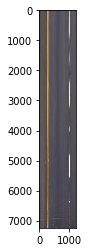

In [57]:
M = cv2.getPerspectiveTransform(src,dst)
birds_eye = cv2.warpPerspective(undistorted_lane_img, M, (1228, 7240))
plt.imshow(birds_eye[:,:,::-1])

### Find Homography
Let's try to add more points to see if we can find a more accurate homography.  We used Gimp to find the pixel coordinates of the endpoints of the lane stripes on the right lane line.  Then we found the corresponding points with the same y coordinate on the left lane line.  We chose these points as we have a good guess where the corresponding destination points should be, as we know the length of the stripes and the distance between stripes.

In [58]:
left_side = np.array([[290,661],[516,507],[538,491],[573,466],[580,461],[593,452],[597,449]],dtype = np.float32)
right_side = np.array([[1014,661],[774,507],[749,491],[710,466],[702,461],[687,452],[683,449]],dtype = np.float32)
src_big = np.vstack((left_side,right_side))

The y distance of the destination points is determined using the fact that 724 pixels is equal to the width of the lane which we take as 12 feet.  We figure out the expected destination y coordinate again using the fact that line stripes are 10 feet long, and there is 30 feet of distance between stripes.

In [59]:
# pixels per foot
ppf = 724/12

In [60]:
left_dst = np.array([[290,120*ppf],[290,90*ppf],[290,80*ppf],[290,50*ppf],[290,40*ppf],[290,10*ppf],[290,0]],dtype = np.float32)
right_dst = np.array([[1014,120*ppf],[1014,90*ppf],[1014,80*ppf],[1014,50*ppf],[1014,40*ppf],[1014,10*ppf],[1014,0]],dtype = np.float32)
dst_big = np.vstack((left_dst,right_dst))

In [61]:
M_big = cv2.findHomography(src_big,dst_big)[0]
print(M_big)

[[ -5.82022707e-01  -1.51096003e+00   1.00566967e+03]
 [ -3.15537561e-05  -1.96071584e+01   8.80776187e+03]
 [  6.82946933e-08  -2.38190618e-03   1.00000000e+00]]


In [62]:
print(M)

[[ -5.72058107e-01  -1.51843278e+00   1.00368407e+03]
 [ -3.21964677e-15  -1.95363240e+01   8.77180948e+03]
 [ -4.74338450e-19  -2.37830273e-03   1.00000000e+00]]


The matrices are fairly similar, but not identical.

In [63]:
Minv = cv2.getPerspectiveTransform(dst,src)
print(Minv)

[[  1.18620690e-01  -7.77235664e-02   5.62718621e+02]
 [  4.44089210e-16  -5.11867022e-02   4.49000000e+02]
 [  0.00000000e+00  -1.21737474e-04   1.00000000e+00]]


In [64]:
X = np.linalg.inv(M)
X = X/X[2,2]
print(X)

[[  1.18620690e-01  -7.77235664e-02   5.62718621e+02]
 [ -8.42132349e-17  -5.11867022e-02   4.49000000e+02]
 [ -1.44018213e-19  -1.21737474e-04   1.00000000e+00]]


In [65]:
birds_eye_big = cv2.warpPerspective(undistorted_lane_img, M_big, (1228, 7240))

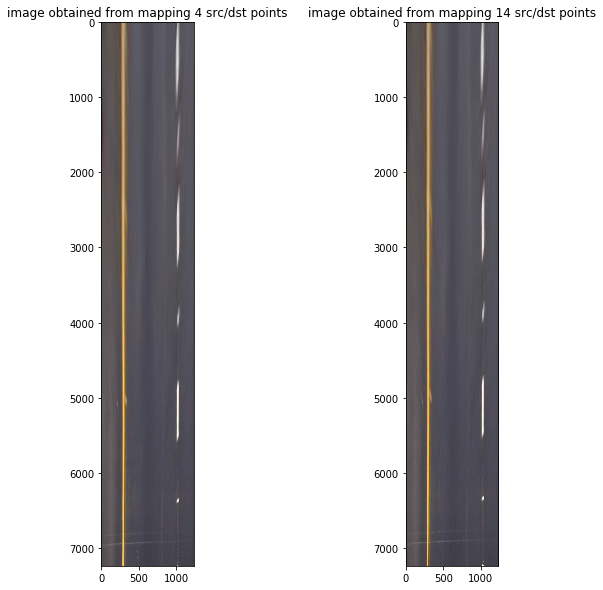

In [66]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.title('image obtained from mapping 4 src/dst points')
plt.imshow(birds_eye[:,:,::-1])
plt.subplot(1,2,2)
plt.title('image obtained from mapping 14 src/dst points')
plt.imshow(birds_eye_big[:,:,::-1])
plt.savefig('birds_eye_comp.png')

The bird's eye view images obtained by these two methods look pretty similar.  There seems to be some inevitable distortion towards the top of the image.

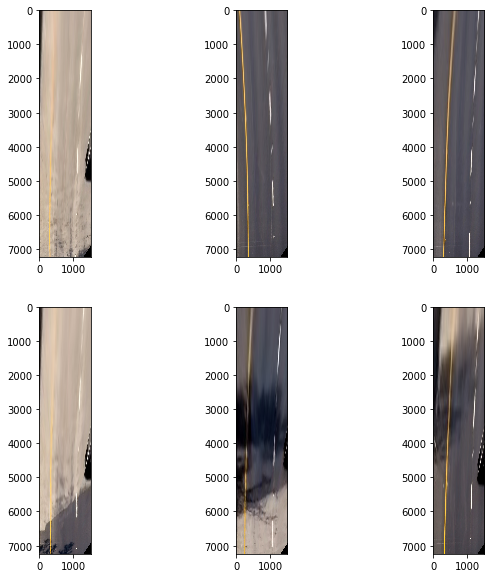

In [67]:
plt.figure(figsize=(10,10))
lane_file_path = './test_images/'
for i in range(1,7):
    img_path = 'test'+str(i)+'.jpg'
    img = cv2.imread(lane_file_path + img_path)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    bird = cv2.warpPerspective(undistorted, M_big, (1500, 7240))
    plt.subplot(2,3,i)
    plt.imshow(bird[:,:,::-1])
plt.savefig('birds_eye_all.png')

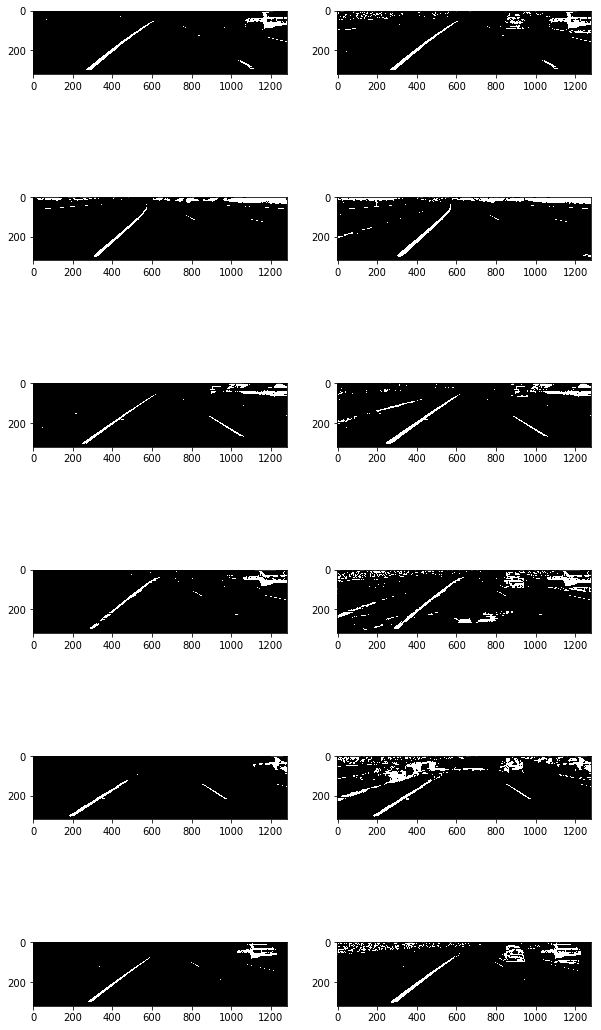

In [68]:
plt.figure(figsize=(10,20))
lane_file_path = './test_images/'
for i in range(1,7):
    img_path = 'test'+str(i)+'.jpg'
    img = cv2.imread(lane_file_path + img_path)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    hls1 = cv2.cvtColor(undistorted,cv2.COLOR_BGR2HLS)
    S1 = hls1[400:,:,2]
    L1 = hls1[400:,:,1]
    abs_sobel = np.abs(cv2.Sobel(S1,cv2.CV_64F,1,0))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    ret, L_thresh = cv2.threshold(L1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    ret,S_thresh = cv2.threshold(S1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    thresh = np.uint8(255*(L_thresh & S_thresh))
    #sobel = cv2.Sobel(thresh,cv2.CV_64F,1,0)
    #bird1 = cv2.warpPerspective(thresh1, M_big, (1500, 7240))
    #bird2 = cv2.warpPerspective(undistorted, M_big, (1500, 7240))
    #hls2 = cv2.cvtColor(bird,cv2.COLOR_BGR2HLS)
    #S2 = hls2[:,:,2]
    #ret,thresh2 = cv2.threshold(S2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    plt.subplot(6,2,2*i-1)
    plt.imshow(thresh,cmap='gray')
    plt.subplot(6,2,2*i)
    plt.imshow(S_thresh,cmap='gray')

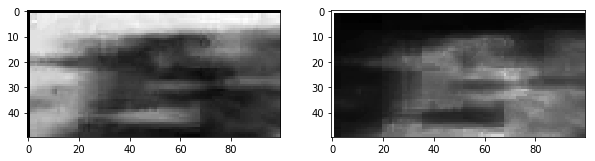

In [69]:
plt.figure(figsize=(10,20))
img_path = 'test'+str(4)+'.jpg'
img = cv2.imread(lane_file_path + img_path)
cv2.rectangle(img,(700,600),(800,650),(255,0,0))
crop = img[600:650,700:800,:]
hls = cv2.cvtColor(crop,cv2.COLOR_BGR2HLS)
s = hls[:,:,2]
plt.imshow(crop[:,:,::-1])
plt.subplot(1,2,1)
plt.imshow(crop[:,:,-1],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(s,cmap='gray')

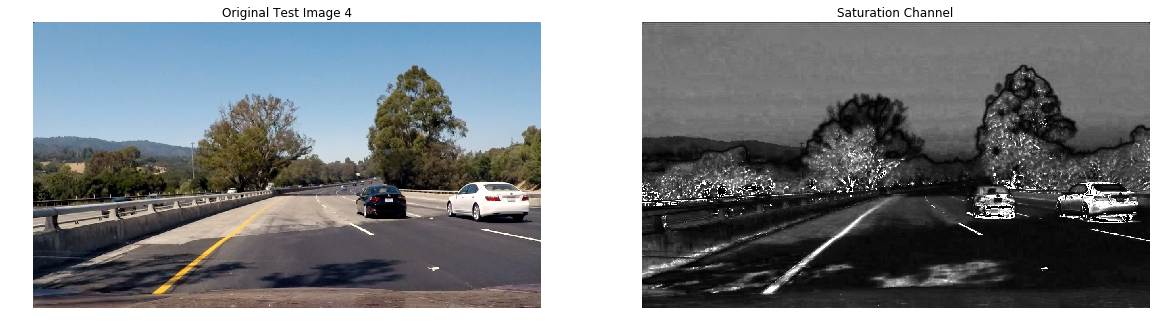

In [70]:
plt.figure(figsize=(20,10))
img_path = 'test'+str(4)+'.jpg'
img = cv2.imread(lane_file_path + img_path)
hls = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
S = hls[:,:,2]
plt.subplot(1,2,1)
plt.title('Original Test Image 4')
plt.axis('off')
plt.imshow(img[:,:,::-1])
plt.subplot(1,2,2)
plt.title('Saturation Channel')
plt.axis('off')
plt.imshow(S,cmap='gray')
plt.savefig('image4_sat.png')

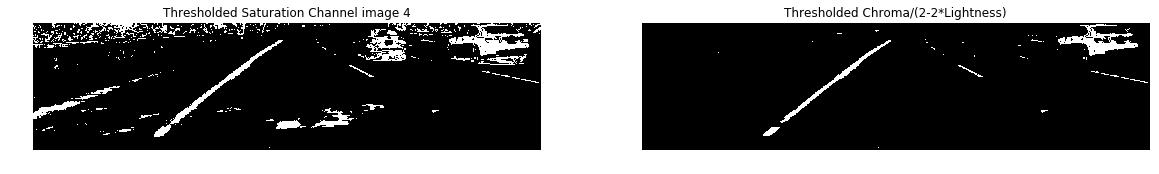

In [71]:
plt.figure(figsize=(20,10))
img_path = 'test'+str(4)+'.jpg'
img = cv2.imread(lane_file_path + img_path)
hls = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
S = hls[:,:,2]
img2 = img/255
V_max = np.max(img2,axis = 2)
V_min = np.min(img2,2)
S2 = (V_max - V_min)/(2-(V_max + V_min)+1e-6)
S2 = np.uint8(255*S2)
S = S[400:,:]
ret,thresh1 = cv2.threshold(S,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
S2 = S2[400:,:]
ret,thresh2 = cv2.threshold(S2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.subplot(1,2,1)
plt.title('Thresholded Saturation Channel image 4')
plt.axis('off')
plt.imshow(thresh1,cmap='gray')
plt.subplot(1,2,2)
plt.title('Thresholded Chroma/(2-2*Lightness)')
plt.axis('off')
plt.imshow(thresh2,cmap='gray')
plt.savefig('thresh_modified_sat.png')

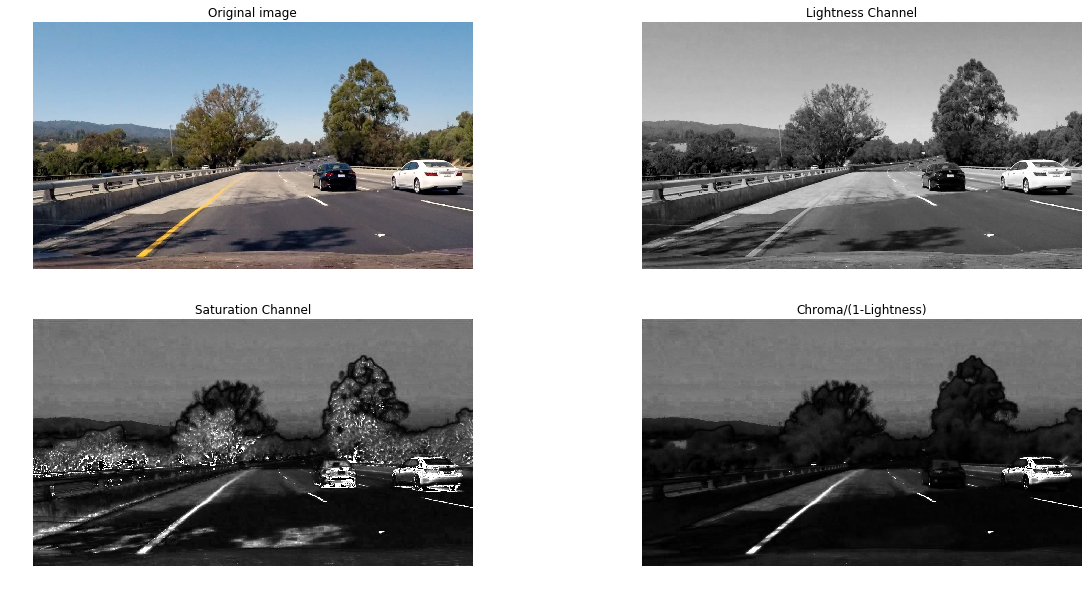

In [72]:
# look closer into definition of saturation
plt.figure(figsize=(20,10))
img_path = 'test'+str(4)+'.jpg'
img = cv2.imread(lane_file_path + img_path)
hls = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
S = hls[:,:,2]
L = hls[:,:,1]
img2 = img/np.max(img)
V_max = np.max(img2,axis = 2)
V_min = np.min(img2,2)
S2 = (V_max - V_min)/(2-(V_max + V_min)+1e-6)
S2 = np.uint8(255*S2/np.max(S2))
S3 = (V_max - V_min)/(V_max + V_min + 1e-6)
S3 = np.uint8(255*S3/np.max(S3))
plt.subplot(2,2,1)
plt.title('Original image')
plt.axis('off')
plt.imshow(img[:,:,::-1])
plt.subplot(2,2,2)
plt.title('Lightness Channel')
plt.axis('off')
plt.imshow(L,cmap='gray')
plt.subplot(2,2,3)
plt.axis('off')
plt.title('Saturation Channel')
plt.imshow(S,cmap='gray')
plt.subplot(2,2,4)
plt.axis('off')
plt.title('Chroma/(1-Lightness)')
plt.imshow(S2,cmap='gray')

## Detecting Lane lines

In [73]:
# takes as input an undistorted image
# for outside of left lane line use upper_thresh = -1.8, lower_thresh = -2.5
# for inside of left lane line use upper_thresh = 1.3, lower_thresh = 0.6
def direction_threshold(img, thresh, kernel_size = 3):
    S = cv2.GaussianBlur(img,(3,3),0)
    sobelx = cv2.Sobel(S,cv2.CV_64F,1,0,ksize = kernel_size)
    sobely = cv2.Sobel(S,cv2.CV_64F,0,1,ksize = kernel_size)
    direction = np.arctan2(sobely,sobelx)
    thresh = np.uint8(255*((direction >= thresh[0]) & (direction <= thresh[1])))
    median = cv2.medianBlur(thresh,15)
    #thresh1 = (direction <= -1.8) & (direction >= -2.5)
    #thresh2 = (direction >= .6) & (direction <= 1.3)
    return median

In [74]:
# takes as input an undistorted image
# use axis = 1 for x-axis, axis = 0 for y-axis
def sobel_thresh(img, axis = (1,0), kernel_size = 3):
    S = cv2.GaussianBlur(img,(5,5),0)
    abs_sobel = np.abs(cv2.Sobel(S,cv2.CV_64F,axis[0],axis[1]))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    blur = cv2.medianBlur(scaled_sobel,5)
    ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #thresh = cv2.medianBlur(thresh,5)
    return thresh

In [75]:
def canny(img, thresh =(1,5)):
    S = cv2.GaussianBlur(img,(5,5),0)
    edges = cv2.Canny(S,thresh[0],thresh[1])
    return edges

In [76]:
# takes as input an undistorted image
# use axis = 1 for x-axis, axis = 0 for y-axis
def mag_thresh(img, kernel_size = 3):
    S = cv2.GaussianBlur(img,(5,5),0)
    sobelx = cv2.Sobel(S,cv2.CV_64F,1,0)
    sobely = cv2.Sobel(S,cv2.CV_64F,0,1)
    mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_mag = np.uint8(255*mag/np.max(mag))
    ret,thresh = cv2.threshold(scaled_mag,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return thresh

In [77]:
def img_transformation(img):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    scaled_undistorted = undistorted/255
    # we just take the formula for distortion in the bright L case
    V_max = np.max(scaled_undistorted,axis = 2)
    V_min = np.min(scaled_undistorted,axis = 2)
    S2 = (V_max - V_min)/(2.-(V_max + V_min)+1e-6)
    S2 = np.uint8(255*S2/np.max(S2))
    S2 = cv2.medianBlur(S2,3)
    S2 = S2[400:,:]
    ret,thresh = cv2.threshold(S2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    thresh = np.vstack((np.zeros(shape = (400,img.shape[1])),thresh)).astype(np.uint8)
    #thresh = cv2.medianBlur(thresh,3)
    bird = cv2.warpPerspective(thresh,M_big,(1500, 7240))
    #bird = cv2.warpPerspective(S2,M_big,(1500, 7240))
    return bird

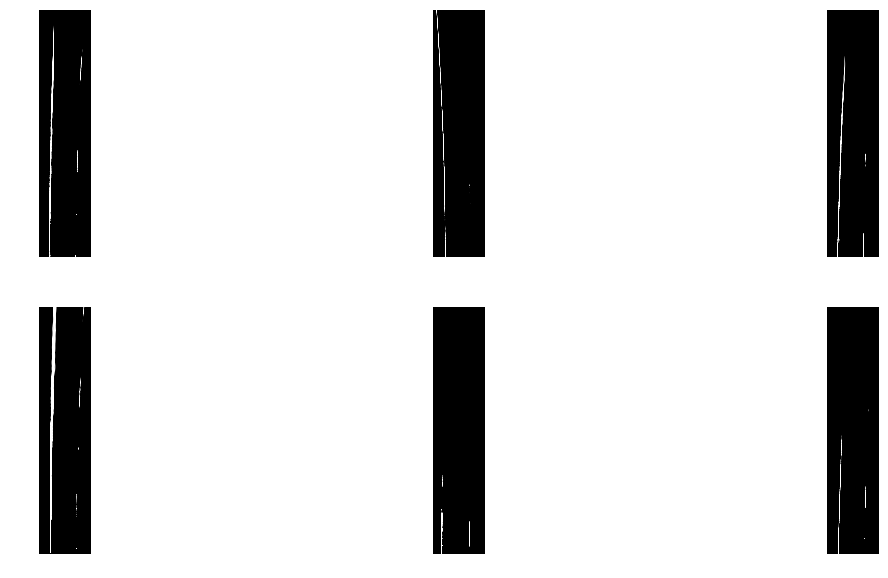

In [78]:
# pipeline cell
plt.figure(figsize = (20,10))
for i in range(1,7):
    img_path = 'test'+str(i)+'.jpg'
    img = cv2.imread(lane_file_path + img_path)
    bird = img_transformation(img)
    plt.subplot(2,3,i)
    plt.axis('off')
    plt.imshow(bird,cmap='gray')

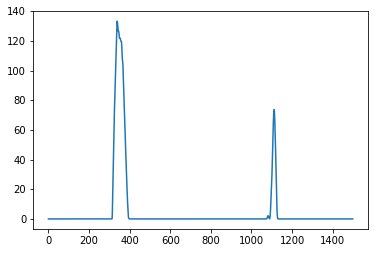

In [79]:
proj = np.average(bird[-2000:,:],0)
plt.plot(proj)